In [69]:
# import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from scipy import signal
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES
import xgrid_utils
import pickle

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [70]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [71]:
# we have tw historical for awi-cm-1-1-lr and ssp245 for awi-cm-1-1-mr

cmip6_models = ['access-cm2',
                'bcc-csm2-mr', 'canesm5', 'cmcc-esm2',
                'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'kace-1-0-g',
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']
# cmip6_models = ['taiesm1']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

# model = cmip6_models[7]

In [72]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirUtil = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/util'
dataDirLens = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/LENS/daily/atm'

In [73]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1

In [74]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load();
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load();
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})

In [75]:
recalc = False

In [76]:
# LOAD ERA5 TX_TW_CORR MEAN

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.sel(time=slice('1981-01-01', '2021-12-31'))

tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')

tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full.sel(latitude=slice(60,-60)))

In [77]:
tw_hist = []
tw_fut = []
tw_chg = []

tx_hist = []
tx_fut = []
tx_chg = []


if recalc:
    for m in cmip6_models:
        print(f'opening {m}')
        cur_tw_hist = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/historical/tw/tw_daily*.nc", concat_dim='time')
        cur_tw_fut = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/ssp245/tw/tw_daily*.nc", concat_dim='time')

        cur_tx_hist = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/historical/tasmax/tasmax_day_*.nc", concat_dim='time')
        cur_tx_fut = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/ssp245/tasmax/tasmax_day_*.nc", concat_dim='time')
        cur_tx_hist['tasmax'] -= 273.15
        cur_tx_fut['tasmax'] -= 273.15

        tw_hist.append(cur_tw_hist)
        tw_fut.append(cur_tw_fut)

        tx_hist.append(cur_tx_hist)
        tx_fut.append(cur_tx_fut)

    with open('cmip6_tx_tw_hist_fut.pkl', 'wb') as file:
        pickle.dump((tw_hist, tw_fut, tw_chg, tx_hist, tx_fut, tx_chg), file)
else:
    # Load the variables from the file
    with open('cmip6_tx_tw_hist_fut.pkl', 'rb') as file:
        tw_hist, tw_fut, tw_chg, tx_hist, tx_fut, tx_chg = pickle.load(file)


In [78]:
tx_chg = []
tw_chg = []
tw_max_chg = []
tx_max_chg = []

global_mean_tx_ts_hist = []
global_mean_tx_ts_fut = []
global_mean_tw_ts_hist = []
global_mean_tw_ts_fut = []

tx_ann_max_chg_spatial = []
tw_ann_max_chg_spatial = []

# Load the variables from the file
for m in range(len(cmip6_models)):
    with open(f'cmip6_tx_tw_spatial_mean_max_{m}.pkl', 'rb') as file:
        cur_tx_chg, cur_tw_chg, cur_tw_max_chg, cur_tx_max_chg, cur_tx_ann_max_chg_spatial, cur_tw_ann_max_chg_spatial, \
        cur_global_mean_tx_ts_hist, cur_global_mean_tx_ts_fut, cur_global_mean_tw_ts_hist, cur_global_mean_tw_ts_fut = pickle.load(file)

        print(f'regridding {m}...')

        regridder = xe.Regridder(land_sea_mask_binary.rename({'latitude':'lat', 'longitude':'lon'}), regridMesh_global, 'bilinear', reuse_weights=True)
        land_sea_mask_binary_regrid = regridder(land_sea_mask_binary)

        regridder = xe.Regridder(cur_tx_ann_max_chg_spatial, regridMesh_global, 'bilinear', reuse_weights=False)
        cur_tx_ann_max_chg_spatial = regridder(cur_tx_ann_max_chg_spatial);
        cur_tw_ann_max_chg_spatial = regridder(cur_tw_ann_max_chg_spatial);

        cur_tx_ann_max_chg_spatial = cur_tx_ann_max_chg_spatial.where(land_sea_mask_binary_regrid)
        cur_tw_ann_max_chg_spatial.where(land_sea_mask_binary_regrid)

        cur_tx_ann_max_chg_spatial = cur_tx_ann_max_chg_spatial.sel(lat=slice(-60,60))
        cur_tw_ann_max_chg_spatial = cur_tw_ann_max_chg_spatial.sel(lat=slice(-60,60))
            
        tx_chg.append(cur_tx_chg)
        tw_chg.append(cur_tw_chg)
        tx_max_chg.append(cur_tx_max_chg)
        tw_max_chg.append(cur_tw_max_chg)
        tx_ann_max_chg_spatial.append(cur_tx_ann_max_chg_spatial)
        tw_ann_max_chg_spatial.append(cur_tw_ann_max_chg_spatial)
        global_mean_tx_ts_hist.append(cur_global_mean_tx_ts_hist)
        global_mean_tx_ts_fut.append(cur_global_mean_tx_ts_fut)
        global_mean_tw_ts_hist.append(cur_global_mean_tw_ts_hist)
        global_mean_tw_ts_fut.append(cur_global_mean_tw_ts_fut)
    

regridding 0...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_144x192_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 1...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_160x320_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 2...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_64x128_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 3...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_192x288_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 4...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_80x180_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 5...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_120x180_120x240.nc 
 Y

In [80]:
cmip6_hist_corr_spatial = []
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []


obs_slope = 0
nn = np.where((~np.isnan(tx_tw_corr_ts.tx_tw_corr.values)))[0]
X = sm.add_constant(range(nn.size))
mdl = sm.OLS(tx_tw_corr_ts.tx_tw_corr.values[nn], X).fit()
obs_slope = mdl.params[1]*10
obs_pval = mdl.pvalues[1]

for model in cmip6_models:
    print(f"loading {model}")
    
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_1981_2100_ssp245_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'lat':'latitude', 'lon':'longitude'})
    cur_corr_ts = xgrid_utils.calc_spatial_mean(cur_tx_tw_corr.tx_tw_corr)
#     cur_corr_ts = cur_tx_tw_corr.tx_tw_corr.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts.values)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn].values, X).fit()
    corr_ts_slopes.append(mdl.params[1]*10)
    corr_ts_pvals.append(mdl.pvalues[1])
    
    # Assign the model as a coordinate in the current data array
    cur_tx_tw_corr = cur_tx_tw_corr.assign_coords(model=model)

    # Add the current data array to the list
    cmip6_hist_corr_spatial.append(cur_tx_tw_corr)
    

# Concatenate along the new dimension 'model'
cmip6_hist_corr_spatial = xr.concat(cmip6_hist_corr_spatial, dim='model')
corr_ts = np.array(corr_ts)

loading access-cm2
loading bcc-csm2-mr
loading canesm5
loading cmcc-esm2
loading fgoals-g3
loading inm-cm4-8
loading inm-cm5-0
loading kace-1-0-g
loading mpi-esm1-2-hr
loading mpi-esm1-2-lr
loading mri-esm2-0
loading noresm2-lm
loading taiesm1


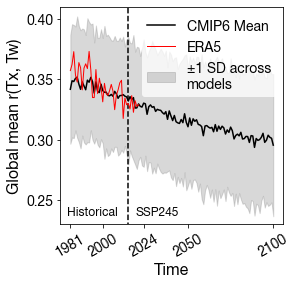

In [105]:
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation across the 'latitude', 'longitude', and 'model' dimensions
mean_vals = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).mean(dim='model')
std_dev = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).std(dim='model')



# Calculate the upper and lower bounds as mean ± 1 standard deviation
upper_bound = mean_vals + std_dev
lower_bound = mean_vals - std_dev

# Assuming 'time' is the dimension along which you want to plot
time = mean_vals['year']  # Adjust this if your time dimension is named differently

plt.figure(figsize=(4, 4))
plt.ylim([.23, .41])
plt.plot(time, mean_vals, label='CMIP6 Mean', color='k')
plt.plot([2015, 2015], [.22, .42], '--k')
plt.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.3, label='±1 SD across\nmodels')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=1, label='ERA5')

plt.text(1994, .24, "Historical", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary
plt.text(2032, .24, "SSP245", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary

plt.xticks([1981, 2000, 2024, 2050, 2100], rotation=30)

plt.xlabel('Time')  # Adjust as necessary
plt.ylabel('Global mean r(Tx, Tw)')  # Adjust as necessary
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

plt.savefig('r(tx,tw)-cmip6-hist-fut.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [82]:
# Initialize a list to store the monthly means for each ensemble member
lens_tx_tw_ensemble_members = []

n_members = 40

# Loop through ensemble members from 1-10
for i in range(1, n_members+1):
    # Load the data for the current ensemble member
    tx_tw_corr_lens = xr.open_dataset(f'tx_tw_corr_lens_member_{i}.nc')
    tx_tw_corr_lens = tx_tw_corr_lens.rename({'__xarray_dataarray_variable__': 'tw'})
    
    tx_tw_corr_lens.load()
    
    # Append the monthly mean to the list
    lens_tx_tw_ensemble_members.append(tx_tw_corr_lens)

# Concatenate along the 'ensemble' dimension
lens_tx_tw_ensemble_members = xr.concat(lens_tx_tw_ensemble_members, dim='ensemble')
lens_tx_tw_ensemble_members['ensemble'] = np.arange(1, n_members+1)  # Assign ensemble member numbers to the 'ensemble' coordinate
lens_tx_tw_ensemble_members = lens_tx_tw_ensemble_members.rename({'lat':'latitude', 'lon':'longitude'})

In [83]:
lens_tx_tw_ensemble_members_spatial_mean = xgrid_utils.calc_spatial_mean(lens_tx_tw_ensemble_members.sel(latitude=slice(-60, 60)))

In [84]:

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    nn = np.where(~np.isnan(y))[0]
    x = np.arange(len(y))
    X = sm.add_constant(x[nn])  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y[nn], X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
lens_tx_tw_corr_slopes = []
lens_tx_tw_corr_pvals = []

for i in lens_tx_tw_ensemble_members_spatial_mean.ensemble.values:
    model_data = lens_tx_tw_ensemble_members_spatial_mean.tw.sel(ensemble=i).values
    slope, pval = calculate_ols_slope(model_data)
    lens_tx_tw_corr_slopes.append(slope*10)
    lens_tx_tw_corr_pvals.append(pval)
    
lens_tx_tw_corr_slopes = xr.DataArray(lens_tx_tw_corr_slopes, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])
lens_tx_tw_corr_pvals = xr.DataArray(lens_tx_tw_corr_pvals, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])


In [85]:
with open(f'lens_global_mean_tx.pkl', 'rb') as file:
    lens_gmt = pickle.load(file)

In [86]:
lens_gmt_slopes = []
lens_r_tx_tw_per_gmt = []

for m in range(len(lens_gmt)):
    X = sm.add_constant(range(lens_gmt[0].values.size))
    mdl = sm.OLS(lens_gmt[m].values, X).fit()
    lens_gmt_slopes.append(mdl.params[1]*10)
    lens_r_tx_tw_per_gmt.append(lens_tx_tw_corr_slopes.values[m]/lens_gmt_slopes[m])
lens_r_tx_tw_per_gmt = np.array(lens_r_tx_tw_per_gmt)

In [87]:
cmip6_gmt_slopes = []
cmip6_gmt_slope_ratio = []
for i in range(len(global_mean_tx_ts_hist)):
    #calc rate of change of gmt in each model
    X = sm.add_constant(np.arange(global_mean_tx_ts_hist[i].values.size))
    mdl = sm.OLS(global_mean_tx_ts_hist[i].values, X).fit()
    cmip6_gmt_slopes.append(mdl.params[1])
    # calc r(tx,tw) per deg c using rate of change of r(tx,tw)
    cmip6_gmt_slope_ratio.append((corr_ts_slopes[i]/10)/mdl.params[1])

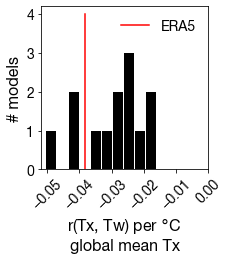

In [88]:
obs_gmt_slope_ratio = -0.038118621780981944
plt.figure(figsize=(3,3))
plt.hist(cmip6_gmt_slope_ratio, fc='black', rwidth=.9)
plt.plot([obs_gmt_slope_ratio,obs_gmt_slope_ratio], [0,4], c='red', label='ERA5')
plt.xticks([-.05, -.04, -.03, -.02, -.01, 0], rotation=45)
plt.ylabel('# models')
plt.xlabel('r(Tx, Tw) per $\degree$C\nglobal mean Tx')
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

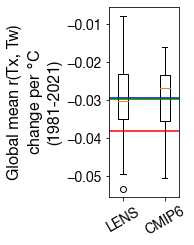

In [104]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.xlim([.5, 1.5])
plt.boxplot([lens_r_tx_tw_per_gmt, cmip6_gmt_slope_ratio], positions=[.7, 1.3])
plt.plot([.5, 1.5], [obs_gmt_slope_ratio, obs_gmt_slope_ratio], '-r', label='ERA5')
plt.plot([.5, 1.5], [np.nanmean(cmip6_gmt_slope_ratio), np.nanmean(cmip6_gmt_slope_ratio)], '-b', label='CMIP6\nmean')
plt.plot([.5, 1.5], [np.nanmean(lens_r_tx_tw_per_gmt), np.nanmean(lens_r_tx_tw_per_gmt)], '-g', label='LENS\nmean')
plt.xticks([.7,1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])
plt.ylabel('Global mean r(Tx, Tw)\nchange per $\degree$C\n(1981-2021)')
# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

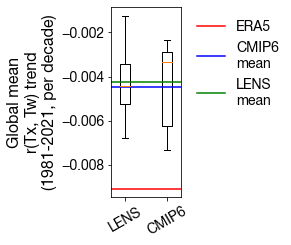

In [103]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
# plt.boxplot(1, lens_tx_tw_corr_slopes)
# plt.boxplot(2, corr_ts_slopes)
plt.boxplot([lens_tx_tw_corr_slopes, corr_ts_slopes], positions=[.7, 1.3])
plt.xlim([.5, 1.5])
plt.plot([0, 2], [obs_slope, obs_slope], '-r', label='ERA5')
plt.plot([0, 2], [np.nanmean(corr_ts_slopes), np.nanmean(corr_ts_slopes)], '-b', label='CMIP6\nmean')
plt.plot([0, 2], [np.nanmean(lens_tx_tw_corr_slopes), np.nanmean(lens_tx_tw_corr_slopes)], '-g', label='LENS\nmean')

plt.ylabel('Global mean\nr(Tx, Tw) trend\n(1981-2021, per decade)')
plt.xticks([.7, 1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])

l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

# plt.savefig('r(tx,tw)-trend-cmip6-lens-era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [106]:
cmip6_r_tx_tw_chg_fut_minus_hist = (xgrid_utils.calc_spatial_mean(corr_fut_spatial).mean(dim=['year']) - xgrid_utils.calc_spatial_mean(corr_spatial).mean(dim=['year'])).tx_tw_corr.values

NameError: name 'corr_fut_spatial' is not defined

In [92]:
plt.figure(figsize=(3,3))
X = sm.add_constant(tx_chg)
mdl_corr_per_deg = sm.OLS(cmip6_r_tx_tw_chg_fut_minus_hist, X).fit()

x1 = .5
x2 = 1.25

plt.scatter(tx_chg, cmip6_r_tx_tw_chg_fut_minus_hist, c='k')
plt.plot([x1, x2], [mdl_corr_per_deg.params[0]+x1*mdl_corr_per_deg.params[1], mdl_corr_per_deg.params[0]+x2*mdl_corr_per_deg.params[1]], '--k',
        label='%.3f\nr(Tx, Tw)\nper $\degree$C'%mdl_corr_per_deg.params[1])
plt.xlabel('Global mean Tx\nchange (2020-2050\nminus 1980-2010)')
plt.ylabel('Global mean r(Tx, Tw)\nchange (2020-2050\nminus 1980-2010)')
plt.xticks([.5, .75, 1, 1.25])
l = plt.legend(fontsize=14)
l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-future.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'cmip6_r_tx_tw_chg_fut_minus_hist' is not defined

<Figure size 216x216 with 0 Axes>

In [93]:
plt.figure(figsize=(4,4))
X = sm.add_constant(x)
mdl_resid = sm.OLS(mdl_tx_tw_max_chg.resid, X).fit()

x1 = -.04
x2 = -.01

plt.scatter(x, mdl_tx_tw_max_chg.resid, c=tx_chg, cmap='Reds', vmin=.25, vmax=1.25,s=150)
plt.plot([x1, x2], [mdl_resid.params[0]+x1*mdl_resid.params[1], mdl_resid.params[0]+x2*mdl_resid.params[1]], '--k')
plt.xlabel('r(Tx, Tw) change')


NameError: name 'x' is not defined

<Figure size 288x288 with 0 Axes>

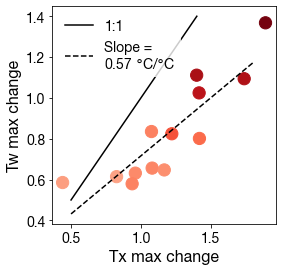

In [94]:
X = sm.add_constant(tx_max_chg)
mdl_tx_tw_max_chg = sm.OLS(tw_max_chg, X).fit()

x1 = .5
x2 = 1.8

plt.figure(figsize=(4,4))
plt.scatter(tx_max_chg,tw_max_chg, c=tx_chg, cmap='Reds', vmin=.25, vmax=1.25,s=150)
# plt.xlim([.5,1.2])
# plt.ylim([.5,1.2])
plt.plot([.5, 1.4], [.5, 1.4], '-k', label='1:1')
plt.plot([x1, x2], [mdl_tx_tw_max_chg.params[0]+x1*mdl_tx_tw_max_chg.params[1], mdl_tx_tw_max_chg.params[0]+x2*mdl_tx_tw_max_chg.params[1]], '--k', label='Slope =\n%.2f $\degree$C/$\degree$C'%mdl_tx_tw_max_chg.params[1])
plt.xlabel('Tx max change')
plt.ylabel('Tw max change')
l = plt.legend(fontsize=14)
l.get_frame().set_linewidth(0)

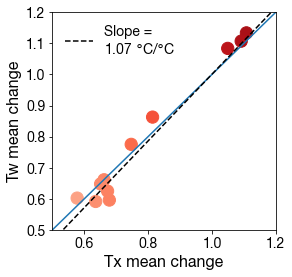

In [95]:
X = sm.add_constant(tx_chg)
mdl = sm.OLS(tw_chg, X).fit()

x1 = .5
x2 = 1.2

plt.figure(figsize=(4,4))
plt.scatter(tx_chg,tw_chg, c=tx_chg, cmap='Reds', vmin=.25, vmax=1.25,s=150)
plt.xlim([.5,1.2])
plt.ylim([.5,1.2])
plt.plot([.5, 1.2], [.5, 1.2])
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', label='Slope =\n%.2f $\degree$C/$\degree$C'%mdl.params[1])
plt.xlabel('Tx mean change')
plt.ylabel('Tw mean change')
l = plt.legend(fontsize=14)
l.get_frame().set_linewidth(0)

In [96]:
era5_tx_on_tx_ts = xr.open_dataset('intermediate/tx_on_tx_ts.nc')
era5_tw_on_tx_ts = xr.open_dataset('intermediate/tw_on_tx_ts.nc')
era5_tw_on_tw_ts = xr.open_dataset('intermediate/tw_on_tw_ts.nc')
era5_tx_on_tw_ts = xr.open_dataset('intermediate/tx_on_tw_ts.nc')

In [11]:
x = np.arange(era5_tx_on_tw_ts.mx2t[0:-1,-1].shape[0])
era5_tx_tw_minus_tx_tx = (era5_tx_on_tw_ts.mx2t[0:-1,-1])-era5_tx_on_tx_ts.mx2t[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tx_tw_minus_tx_tx.values,X).fit()
era5_tx_tw_vs_tx_tx_trend = mdl.params[1]*10
era5_tx_tw_vs_tx_tx_pval = mdl.pvalues[1]

era5_tw_tx_minus_tw_tw = (era5_tw_on_tx_ts.tw[:,-1])-era5_tw_on_tw_ts.tw[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tw_tx_minus_tw_tw.values,X).fit()
era5_tw_tx_vs_tw_tw_trend = mdl.params[1]*10
era5_tw_tx_vs_tw_tw_pval = mdl.pvalues[1]

In [26]:
tx_on_tww_ds = []
tx_on_txx_ds = []
tw_on_tww_ds = []
tw_on_txx_ds = []

# Loop through each model
for model in cmip6_models[0:5]:
    # Construct the filename
    filename = f'output/cmip6/tx_on_tww_1981_2100_ssp245_{model}.nc'
    
    # Open the dataset and append to the list
    ds = xr.open_dataset(filename)
    tx_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tx_on_txx_{model}.nc'
    ds = xr.open_dataset(filename)
    tx_on_txx_ds.append(ds)

    filename = f'output/cmip6/tw_on_tww_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tw_on_txx_1981_2100_ssp245_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_txx_ds.append(ds)

    
# Concatenate all datasets along the 'model' dimension
tx_on_tww_ds = xr.concat(tx_on_tww_ds, dim='model')
tx_on_tww_ds['model'] = cmip6_models  
tx_on_tww_ds = tx_on_tww_ds.rename({'__xarray_dataarray_variable__':'tx_on_tww'})

tx_on_txx_ds = xr.concat(tx_on_txx_ds, dim='model')
tx_on_txx_ds['model'] = cmip6_models  
tx_on_txx_ds = tx_on_txx_ds.rename({'__xarray_dataarray_variable__':'tx_on_txx'})

tw_on_tww_ds = xr.concat(tw_on_tww_ds, dim='model')
tw_on_tww_ds['model'] = cmip6_models  
tw_on_tww_ds = tw_on_tww_ds.rename({'__xarray_dataarray_variable__':'tw_on_tww'})

tw_on_txx_ds = xr.concat(tw_on_txx_ds, dim='model')
tw_on_txx_ds['model'] = cmip6_models  
tw_on_txx_ds = tw_on_txx_ds.rename({'__xarray_dataarray_variable__':'tw_on_txx'})

ValueError: arguments without labels along dimension 'time' cannot be aligned because they have different dimension sizes: {120, 119}

In [23]:
tx_on_txx_ds = tx_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_tww_ds = tx_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_txx_ds = tw_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_tww_ds = tw_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})

cmip6_tx_tw_minus_tx_tx_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx)
cmip6_tw_tx_minus_tw_tw_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww)



AttributeError: 'list' object has no attribute 'rename'

In [ ]:
# Calculate the spatial average for each model and time
# cmip6_tx_tw_minus_tx_tx_spatial_mean = (tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx).mean(dim=['lat', 'lon'])
# cmip6_tw_tx_minus_tw_tw_spatial_mean = (tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww).mean(dim=['lat', 'lon'])

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    x = np.arange(len(y))
    X = sm.add_constant(x)  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y, X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
cmip6_tx_tw_minus_tx_tx_slopes = []
cmip6_tx_tw_minus_tx_tx_pvals = []

cmip6_tw_tx_minus_tw_tw_slopes = []
cmip6_tw_tx_minus_tw_tw_pvals = []

for model in cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values:
    model_data = cmip6_tx_tw_minus_tx_tx_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tx_tw_minus_tx_tx_slopes.append(slope*10)
    cmip6_tx_tw_minus_tx_tx_pvals.append(pval)
    
    model_data = cmip6_tw_tx_minus_tw_tw_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tw_tx_minus_tw_tw_slopes.append(slope*10)
    cmip6_tw_tx_minus_tw_tw_pvals.append(pval)

cmip6_tx_tw_minus_tx_tx_slopes = xr.DataArray(cmip6_tx_tw_minus_tx_tx_slopes, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])
cmip6_tx_tw_minus_tx_tx_pvals = xr.DataArray(cmip6_tx_tw_minus_tx_tx_pvals, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])

cmip6_tw_tx_minus_tw_tw_slopes = xr.DataArray(cmip6_tw_tx_minus_tw_tw_slopes, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])
cmip6_tw_tx_minus_tw_tw_pvals = xr.DataArray(cmip6_tw_tx_minus_tw_tw_pvals, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])



Text(0, 0.5, 'Global mean\nTx|Tw - $Tx_{100}$ trend\n($\\degree$C per decade)')

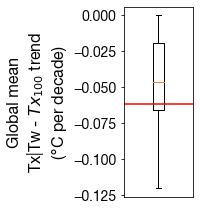

In [121]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tx_tw_minus_tx_tx_slopes)
plt.plot([.5, 1.5], [era5_tx_tw_vs_tx_tx_trend, era5_tx_tw_vs_tx_tx_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$ trend\n($\degree$C per decade)')

Text(0, 0.5, 'Global mean\nTw|Tx - $Tw_{100}$ trend\n($\\degree$C per decade)')

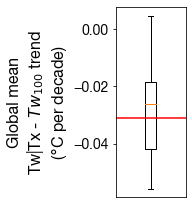

In [122]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tw_tx_minus_tw_tw_slopes)
plt.plot([.5, 1.5], [era5_tw_tx_vs_tw_tw_trend, era5_tw_tx_vs_tw_tw_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$ trend\n($\degree$C per decade)')

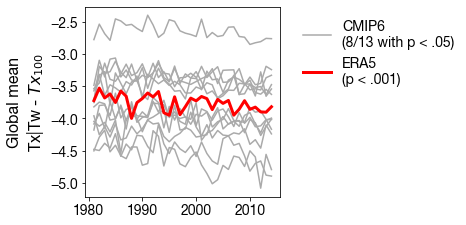

In [123]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[:,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tx_tw_minus_tx_tx_pvals.values<.05)[0].size, cmip6_tx_tw_minus_tx_tx_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[:,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tx_tw_minus_tx_tx[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

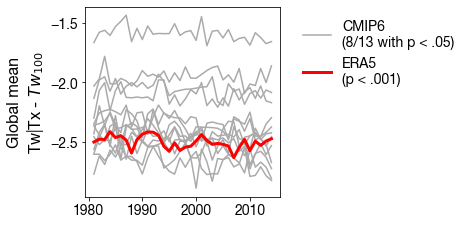

In [32]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tw_tx_minus_tw_tw_pvals.values<.05)[0].size, cmip6_tw_tx_minus_tw_tw_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tw_tx_minus_tw_tw[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

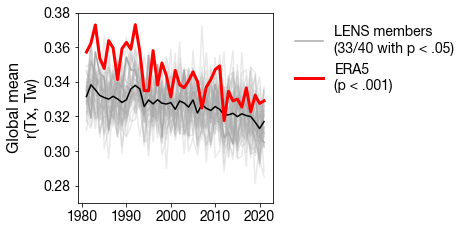

In [215]:
plt.figure(figsize=(3.5,3.5))
plt.ylim([.27, .38])

plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,0], c='#aaaaaa', alpha=1, label='LENS members\n(%d/%d with p < .05)'%(np.where(lens_tx_tw_corr_pvals<.05)[0].size, lens_tx_tw_corr_pvals.size))
plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,:], c='#aaaaaa', alpha=.25)
plt.plot(np.arange(1981,2021+1), np.nanmean(lens_tx_tw_ensemble_members_spatial_mean.tw.values.T, axis=1), c='k')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')

plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

[Text(0.7, 0, 'LENS'), Text(1.3, 0, 'CMIP6')]

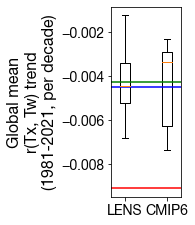

In [18]:
## tx_tw_corr_mean_regrid = tx_tw_corr_mean.rename({'latitude':'lat', 'longitude':'lon'})
regridder = xe.Regridder(tx_tw_corr_mean_regrid, regridMesh_global, 'bilinear', reuse_weights=False)
tx_tw_corr_mean_regrid = regridder(tx_tw_corr_mean_regrid.tx_tw_corr)
tx_tw_corr_mean_regrid = tx_tw_corr_mean_regrid.sel(lat=slice(-60,60))

NameError: name 'tx_tw_corr_mean_regrid' is not defined

NameError: name 'tx_tw_corr_ts' is not defined

In [22]:
cmip6_tx_tw_corr_detrend = np.full(corr_ts.shape, np.nan)
cmip6_tx_tw_minus_tx_tx_detrend = np.full(cmip6_tx_tw_minus_tx_tx_spatial_mean.shape, np.nan)
cmip6_tw_tx_minus_tw_tw_detrend = np.full(cmip6_tw_tx_minus_tw_tw_spatial_mean.shape, np.nan)

cmip6_tx_tw_minus_tx_tx_r2 = np.full([len(cmip6_models)], np.nan)
cmip6_tw_tx_minus_tw_tw_r2 = np.full([len(cmip6_models)], np.nan)

for m in range(len(cmip6_models)):
    cmip6_tx_tw_corr_detrend[m,:] = signal.detrend(corr_ts[m,:])
    cmip6_tx_tw_minus_tx_tx_detrend[m,:] = signal.detrend(cmip6_tx_tw_minus_tx_tx_spatial_mean[m,:])
    cmip6_tw_tx_minus_tw_tw_detrend[m,:] = signal.detrend(cmip6_tw_tx_minus_tw_tw_spatial_mean[m,:])
    
    X = sm.add_constant(cmip6_tx_tw_corr_detrend[m, :])
    mdl_tx_tw_minus_tx_tx = sm.OLS(cmip6_tx_tw_minus_tx_tx_detrend[m, :], X).fit()
    mdl_tw_tx_minus_tw_tw = sm.OLS(cmip6_tw_tx_minus_tw_tw_detrend[m, :], X).fit()
    
    cmip6_tx_tw_minus_tx_tx_r2[m] = mdl_tx_tw_minus_tx_tx.rsquared
    cmip6_tw_tx_minus_tw_tw_r2[m] = mdl_tw_tx_minus_tw_tw.rsquared


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tx_tw_minus_tx_tx_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tx | $Tw_{100}$ - $Tx_{100}$')

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tw_tx_minus_tw_tw_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tw | $Tx_{100}$ - $Tw_{100}$')

In [ ]:
cmip6_tx_tw_corr_detrend_norm = cmip6_tx_tw_corr_detrend-np.nanmean(cmip6_tx_tw_corr_detrend, axis=0)
cmip6_tw_tx_minus_tw_tw_detrend_norm = cmip6_tw_tx_minus_tw_tw_detrend-np.nanmean(cmip6_tw_tx_minus_tw_tw_detrend, axis=0)
cmip6_tx_tw_minus_tx_tx_detrend_norm = cmip6_tx_tw_minus_tx_tx_detrend-np.nanmean(cmip6_tx_tw_minus_tx_tx_detrend, axis=0)

In [ ]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tw_tx_minus_tw_tw_detrend_norm.reshape([cmip6_tw_tx_minus_tw_tw_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTw | $Tx_{100}$ - $Tw_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

In [ ]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tx_tw_minus_tx_tx_detrend_norm.reshape([cmip6_tx_tw_minus_tx_tx_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTx | $Tw_{100}$ - $Tx_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean_regrid

c = plt.pcolormesh(tx_tw_corr_mean_regrid.lon, tx_tw_corr_mean_regrid.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values - tx_tw_corr_mean_regrid

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(1.25,3.5))
plt.ylim([-.012, 0])
plt.boxplot(corr_ts_slopes)
plt.plot([.5, 1.5], [obs_slope, obs_slope], '-r')
plt.xticks([])
plt.ylabel('Global mean\nr(Tx, Tw) trend\n(per decade)')

In [ ]:
np.where(np.array(corr_ts_pvals)<.05)[0].size,np.array(corr_ts_pvals).size

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[0,0:34].T, c='#aaaaaa', label='CMIP6\n(8/18 with p < .05)')
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[1:,0:34].T, c='#aaaaaa')
plt.plot(tx_tw_corr_ts.time.dt.year.values, tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')
plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [ ]:
# CALC SPATIAL TREND IN CORR

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
cmip6_var = xr.open_dataset('tx_tw_corr_%s.nc'%cmip6_models[0])
cmip6_var = cmip6_var.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
cmip6_var['year'] = time_dim
cmip6_var = cmip6_var.chunk(chunks={"year": -1, "lat": 50, "lon": 50})
cmip6_var = cmip6_var.chunk({"year": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})

In [ ]:

def linregress_ufunc(x, y):
    # Remove rows where either x or y is nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # If all values are nan or the length of x, y are less than 2, return nan
    if len(x) < 2 or len(y) < 2:
        return (np.nan, np.nan)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return slope, p_value

# rest of the code remains the same


def apply_trend_and_pvalue(ds, time_dim='year', x_dim='lon', y_dim='lat'):
    # Extract the year information from the time coordinates
    time_years = ds[time_dim].dt.year.values
    unique_years = np.unique(time_years)
    
    # Broadcast unique_years along the time dimension
    unique_years_broadcasted = xr.DataArray(unique_years, dims=[time_dim], coords={time_dim: ds[time_dim]})
    
    trend, p_value = xr.apply_ufunc(
        linregress_ufunc,
        unique_years_broadcasted,
        ds,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )

    trend = trend.rename("tx_tw_corr_trend")
    p_value = p_value.rename("tx_tw_corr_trend_p_value")
    
    return xr.merge([trend, p_value])



